전세계 최대 헤지펀드인 Bridgewater Associates의 창업자 Ray Dalio가 만든 전략이 있습니다. 주식 30%, 중기 국채 15%, 장기 국채 40%, 금 7.5%, 원자재 7.5% 비율로 가져갑니다. 주식/국채/금/현금으로 만든 영구 포트폴리오나 Goldenbutterfly(황금나비) 전략과 비슷하지만, 현금을 가져가지 않는 대신 원자재를 가져가 기대 이상의 인플레이션 대응에 더 큰 비중을 두었습니다.

In [1]:
import pandas as pd
import pandas_datareader.data as web
import datetime
import backtrader as bt
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import pyfolio as pf
import quantstats
plt.rcParams["figure.figsize"] = (10, 6) # (w, h)

C:\ProgramData\Anaconda3\lib\site-packages\pyfolio\pos.py:27: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; mutltipliers will not be applied' +


원자재 ETF인 GSG 데이터가 2006-07-21부터 구해지므로 그때부터 시작합니다.

In [2]:
start = '2006-07-21'
end = '2021-02-12'

vtsmx = web.DataReader('VTSMX', 'yahoo', start, end)['Adj Close'].to_frame("Close")
vfitx = web.DataReader('VFITX', 'yahoo', start, end)['Adj Close'].to_frame("Close")
vustx = web.DataReader('VUSTX', 'yahoo', start, end)['Adj Close'].to_frame("Close")
gld = web.DataReader('GLD', 'yahoo', start, end)['Adj Close'].to_frame("Close")
gsg = web.DataReader('GSG', 'yahoo', start, end)['Adj Close'].to_frame("Close")

Backtrader 패키지의 input 형태를 맞춥니다.

In [3]:
for column in ['Open', 'High', "Low"]:
    vtsmx[column] = vtsmx["Close"]
    vfitx[column] = vfitx['Close']
    vustx[column] = vustx["Close"]
    gld[column] = gld["Close"]
    gsg[column] = gsg["Close"]

주식 30%, 중기 국채 15%, 장기 국채 40%, 금 7.5%, 원자재 7.5%를 보유하면서 20 거래일마다 리밸런싱합니다.

In [4]:
class AssetAllocation_AllSeasons(bt.Strategy):
    params = (
        ('Equity',0.3),
        ('InterTreasury', 0.15),
        ('LongTreasury', 0.4),
        ('Gold', 0.075),
        ('Commodities', 0.075)
    )
    def __init__(self):
        self.VTSMX = self.datas[0]
        self.VFITX = self.datas[1]
        self.VUSTX = self.datas[2]
        self.GLD = self.datas[3]
        self.GSG = self.datas[4]
        self.counter = 0
        
    def next(self):
        if  self.counter % 20 == 0:
            self.order_target_percent(self.VTSMX, target=self.params.Equity)
            self.order_target_percent(self.VFITX, target=self.params.InterTreasury)
            self.order_target_percent(self.VUSTX, target=self.params.LongTreasury)
            self.order_target_percent(self.GLD, target=self.params.Gold)
            self.order_target_percent(self.GSG, target=self.params.Commodities)
        self.counter += 1

In [5]:
cerebro = bt.Cerebro()

cerebro.broker.setcash(1000000)

VTSMX = bt.feeds.PandasData(dataname = vtsmx)
VFITX = bt.feeds.PandasData(dataname = vfitx)
VUSTX = bt.feeds.PandasData(dataname = vustx)
GLD = bt.feeds.PandasData(dataname = gld)
GSG = bt.feeds.PandasData(dataname = gsg)

cerebro.adddata(VTSMX)
cerebro.adddata(VFITX)
cerebro.adddata(VUSTX)
cerebro.adddata(GLD)
cerebro.adddata(GSG)

cerebro.addstrategy(AssetAllocation_AllSeasons)

cerebro.addanalyzer(bt.analyzers.PyFolio, _name = 'PyFolio')

results = cerebro.run()
strat = results[0]

portfolio_stats = strat.analyzers.getbyname('PyFolio')
returns, positions, transactions, gross_lev = portfolio_stats.get_pf_items()
returns.index = returns.index.tz_convert(None)

quantstats.reports.html(returns, output = 'Report_AssetAllocation_AllSeasons.html', title='AssetAllocation_AllSeasons')

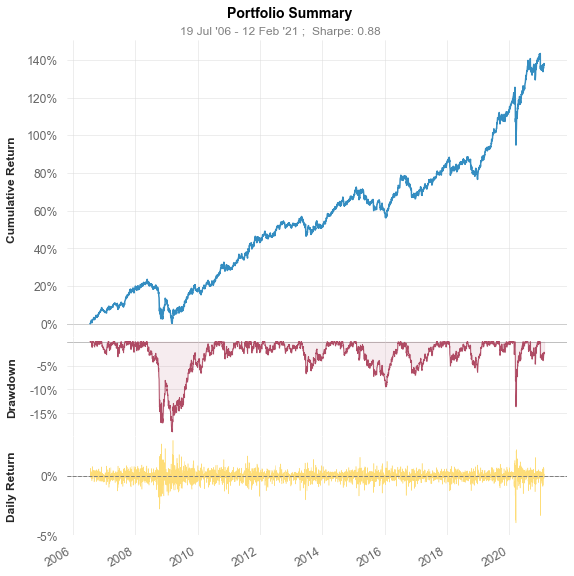

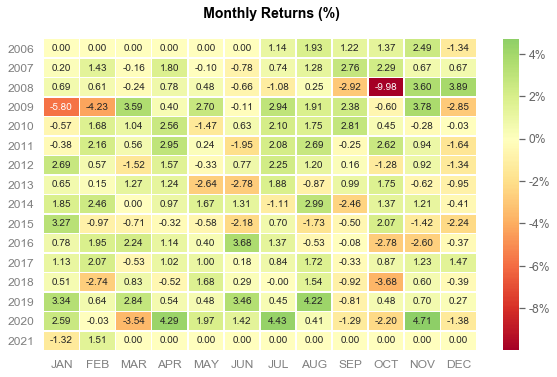

In [6]:
quantstats.reports.plots(returns, mode='basic')

In [7]:
quantstats.reports.metrics(returns, mode='full')

                           Strategy
-------------------------  ----------
Start Period               2006-07-20
End Period                 2021-02-12
Risk-Free Rate             0.0%
Time in Market             100.0%

Cumulative Return          137.28%
CAGR%                      6.11%
Sharpe                     0.88
Sortino                    1.23
Max Drawdown               -18.85%
Longest DD Days            796
Volatility (ann.)          7.07%
Calmar                     0.32
Skew                       -0.55
Kurtosis                   7.15

Expected Daily %           0.02%
Expected Monthly %         0.49%
Expected Yearly %          5.55%
Kelly Criterion            7.91%
Risk of Ruin               0.0%
Daily Value-at-Risk        -0.71%
Expected Shortfall (cVaR)  -0.71%

Payoff Ratio               0.94
Profit Factor              1.17
Common Sense Ratio         1.14
CPC Index                  0.61
Tail Ratio                 0.98
Outlier Win Ratio          3.56
Outlier Loss Ratio         3.